In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def plot_series(time, series, format='-', start=0, end=None, label=None):
  plt.plot(time[start:end], series[start:end], format, label = label)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)

In [ ]:
# trend and seasonality

In [9]:
def trend(time, slop=0):
  return time * slop

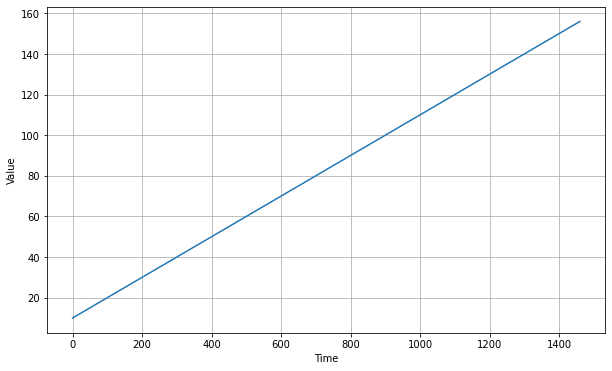

In [10]:
time = np.arange(4*365+1)
baseline = 10
series = baseline + trend(time, 0.1)

plt.figure(figsize = (10,6))
plot_series(time, series)
plt.show()

In [ ]:
time

array([   0,    1,    2, ..., 1458, 1459, 1460])

In [ ]:
series

array([ 10. ,  10.1,  10.2, ..., 155.8, 155.9, 156. ])

In [ ]:
# seasonal pattern

In [11]:
def seasonal_pattern(season_time):
  return np.where(season_time>0.4, np.cos(2*np.pi*season_time), 1/np.exp(3*season_time))

In [12]:
def sesonality(time, period, amplitude=1, phase = 0):
  season_time = ((time+phase)%period)/period
  return amplitude * seasonal_pattern(season_time)

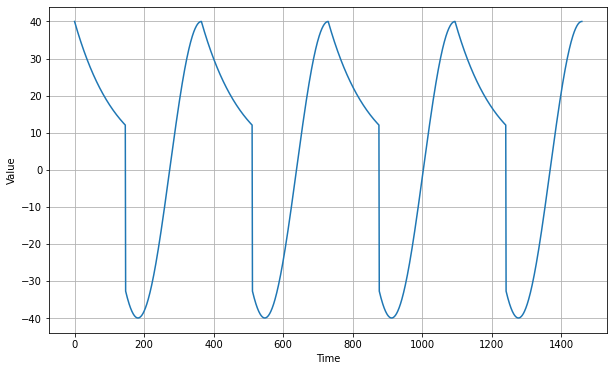

In [13]:
amplitude =40
series = sesonality(time, period=365, amplitude = amplitude)

plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

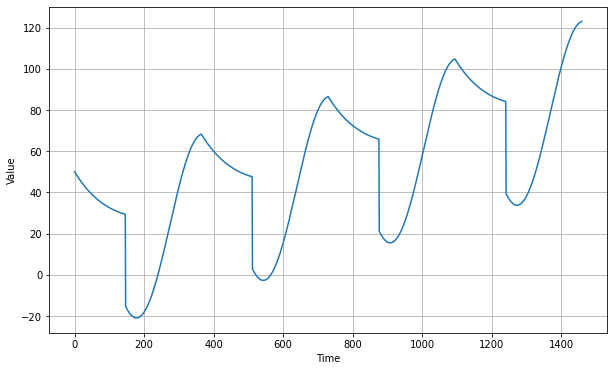

In [14]:
slop = 0.05
series = baseline+ trend(time, slop)+sesonality(time, period=365, amplitude = amplitude)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [15]:
def white_noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

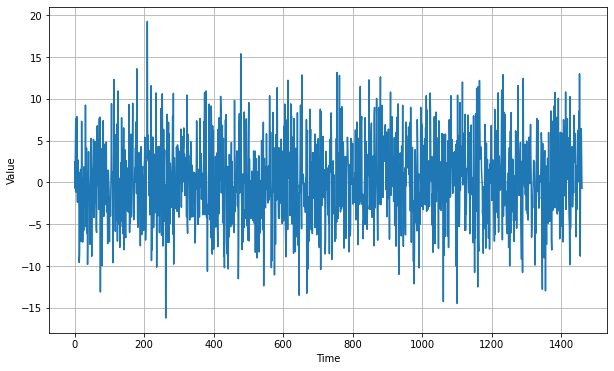

In [16]:
noise_level = 5
noise = white_noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, noise)
plt.show()

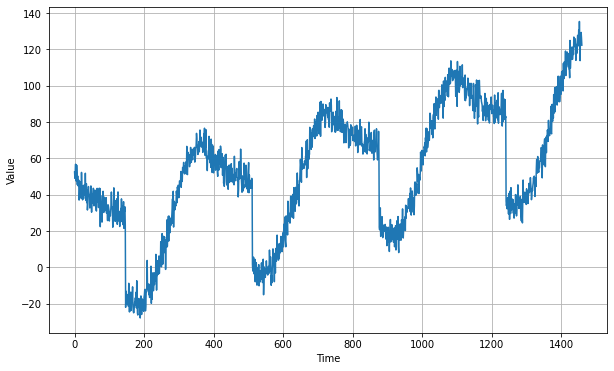

In [17]:
series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [18]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [19]:
naive_forecast = series[split_time-1:-1]

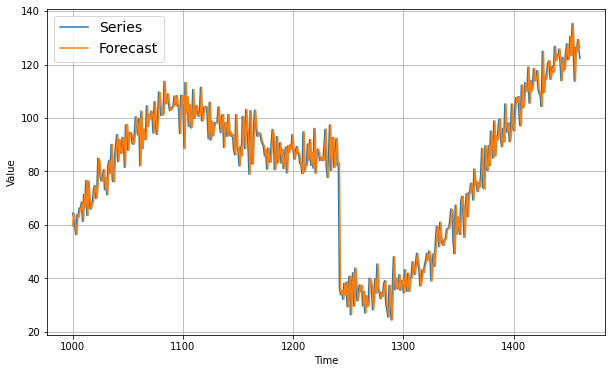

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, naive_forecast, label="Forecast")

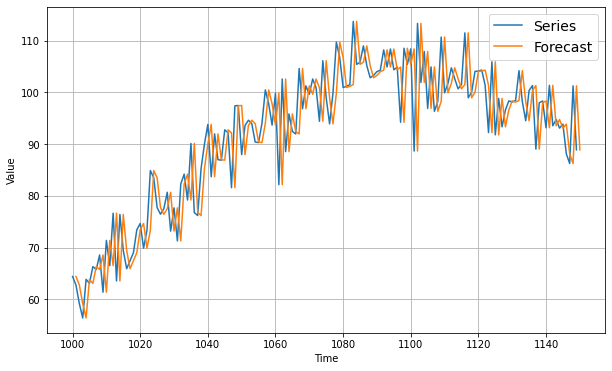

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [22]:
error = naive_forecast - x_valid
abs_error = np.abs(error)
mae = np.mean(abs_error)
mae

5.7914619318917255

In [23]:
import tensorflow as tf

In [24]:
tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.791461931891725

In [25]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

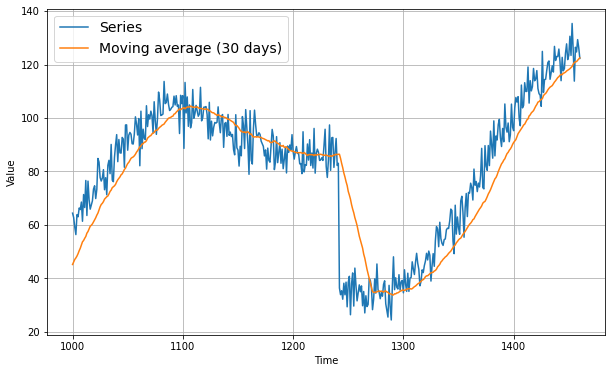

In [26]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

8.470707769023145

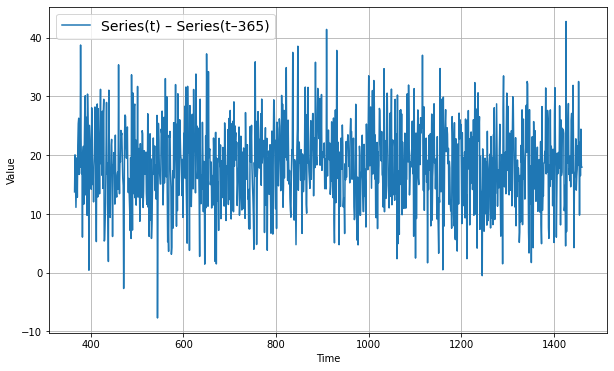

In [28]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

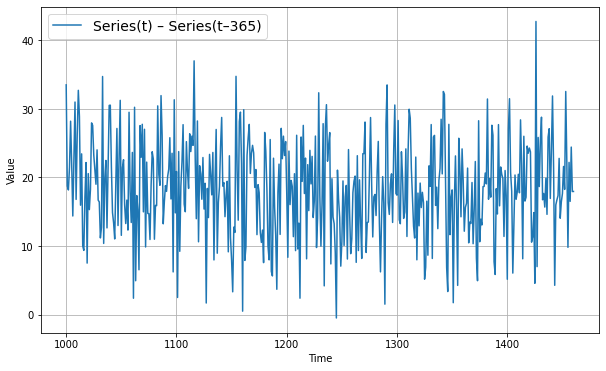

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

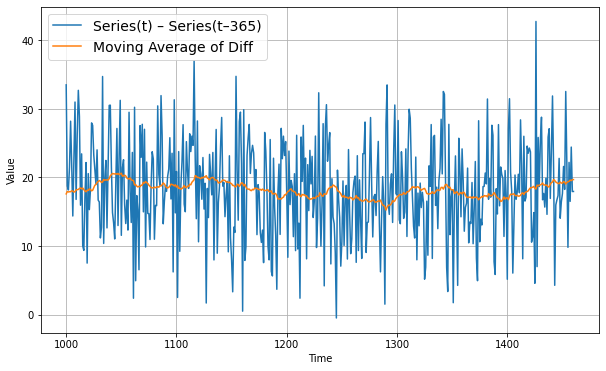

In [30]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

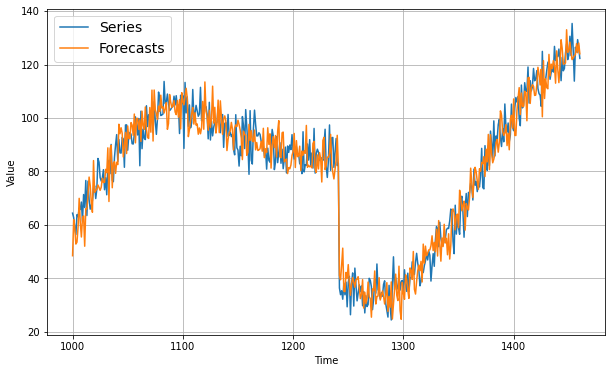

In [31]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [32]:
tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.839310562995897

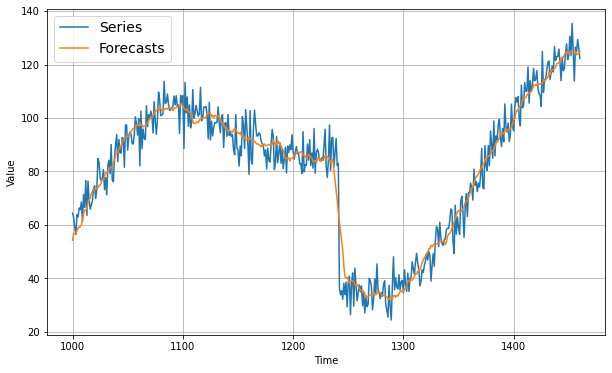

In [33]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [34]:
# time windows
import tensorflow as tf
dataset = tf.data.Dataset.range(10)
for val in dataset:
  print(val)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [35]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift =1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window : (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size = 10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
  print('x= ', x.numpy())
  print('y= ', y.numpy())

x=  [[2 3 4 5]
 [5 6 7 8]]
y=  [[6]
 [9]]
x=  [[0 1 2 3]
 [3 4 5 6]]
y=  [[4]
 [7]]
x=  [[4 5 6 7]
 [1 2 3 4]]
y=  [[8]
 [5]]


In [36]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift = 1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.shuffle(buffer_size=shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [37]:
import numpy as np
import matplotlib.pyplot as plt


In [38]:


window_size = 30
train_set = window_dataset(x_train, window_size)
val_set = window_dataset(x_valid, window_size)

In [ ]:
model = tf.keras.Sequential(
    tf.keras.layers.Dense(1, input_shape=[window_size])
)
optimiser = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(optimizer = optimiser,
              loss = tf.keras.losses.Huber(),
              metrics = ['mae'])
model.fit(train_set, epochs=100, validation_data = val_set)

In [40]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1, drop_remainder= True)
  ds = ds.flat_map(lambda window: window.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [44]:
lin_forecast = model_forecast(model, series[split_time-window_size:-1], window_size)[:,0]

15/15 [==============================] - 0s 6ms/step


In [45]:
lin_forecast.shape

(461,)

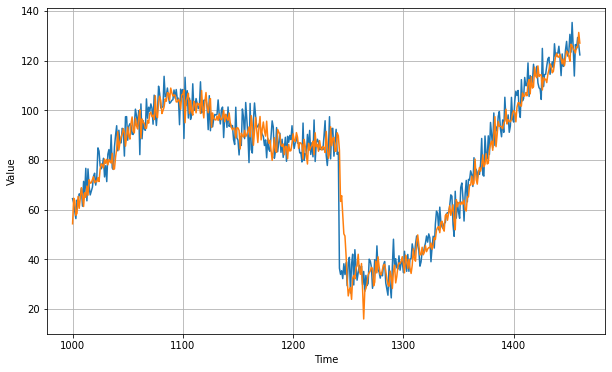

In [46]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [47]:
tf.keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.2483835